# Testing the effects of varying corpus sizes on DeepDive performance

*DeepDive v0.7.1 running on `kylo` -- 4 cores / 64GB RAM / tmp and database paths on 1TB HDD*

PLOS full corpus size as downloaded from http://deepdive.stanford.edu/doc/opendata/: 123,668 documents

**Testing:**
* ***Run time***
* ***RAM usage***
        free -s 1 -t > "test_ram_"`date +%F_%H%M%S`".out"
* ***Disk space usage***
        FILENAME="test_disk_usage_"`date +%F_%H%M%S`".out";
        while true; do df >> $FILENAME 2> /dev/null; echo >> $FILENAME; sleep 1; done
* ***Accuracy***
    * best way to measure this?

**with:**
* full corpus (~123k)
* 60k documents
* 30k documents
* 15k documents
* 7k documents
* 3k documents

        kylo perf_tests> for i in `ls -d /disk/plos_*conll`; do echo $i; ls $i | wc -l; echo "----"; done
        /disk/plos_15k_conll
        15000
        ----
        /disk/plos_30k_conll
        30000
        ----
        /disk/plos_3k_conll
        3000
        ----
        /disk/plos_60k_conll
        60000
        ----
        /disk/plos_7k_conll
        7000
        ----
        /disk/plos_full_conll
        123688
        ----


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn
seaborn.set()

In [2]:
corpus_size_tests_dir = '../../../corpus_size_tests/'

corpus_size_directories = !ls {corpus_size_tests_dir}
corpus_size_directories = [corpus_size_tests_dir+dir_name for dir_name in corpus_size_directories]
corpus_size_directories

['../../../corpus_size_tests/123k',
 '../../../corpus_size_tests/15k',
 '../../../corpus_size_tests/30k',
 '../../../corpus_size_tests/3k',
 '../../../corpus_size_tests/60k',
 '../../../corpus_size_tests/7k']

In [3]:
!ls {corpus_size_directories[2]}

inference_bucketed_30k.csv            test_disk_usage_2016-02-11_103117.out
test_cpu_2016-02-11_103116.out        test_ram_2016-02-11_103118.out


In [4]:
from glob import glob
from collections import defaultdict

corpus_data_dict = defaultdict(dict)

for corpus_size_dir in corpus_size_directories:
    corpus_size = corpus_size_dir.split('/')[-1]
    generic_test_data = corpus_size_dir+'/test_{}*.out'
    corpus_data_dict[corpus_size]['cpu'] = glob(generic_test_data.format('cpu'))[0]
    corpus_data_dict[corpus_size]['ram'] = glob(generic_test_data.format('ram'))[0]
    corpus_data_dict[corpus_size]['disk'] = glob(generic_test_data.format('disk'))[0]

corpus_data_dict

defaultdict(dict,
            {'123k': {'cpu': '../../../corpus_size_tests/123k/test_cpu_2016-02-12_093800.out',
              'disk': '../../../corpus_size_tests/123k/test_disk_usage_2016-02-12_093802.out',
              'ram': '../../../corpus_size_tests/123k/test_ram_2016-02-12_093801.out'},
             '15k': {'cpu': '../../../corpus_size_tests/15k/test_cpu_2016-02-11_140819.out',
              'disk': '../../../corpus_size_tests/15k/test_disk_usage_2016-02-11_140820.out',
              'ram': '../../../corpus_size_tests/15k/test_ram_2016-02-11_140818.out'},
             '30k': {'cpu': '../../../corpus_size_tests/30k/test_cpu_2016-02-11_103116.out',
              'disk': '../../../corpus_size_tests/30k/test_disk_usage_2016-02-11_103117.out',
              'ram': '../../../corpus_size_tests/30k/test_ram_2016-02-11_103118.out'},
             '3k': {'cpu': '../../../corpus_size_tests/3k/test_cpu_2016-02-11_195511.out',
              'disk': '../../../corpus_size_tests/3k/test_disk_us

*manually specify rough timing endpoints for data collection*

In [5]:
corpus_data_endpoints = {'123k': 50000,
                         '60k': 24000,
                         '30k': 10000,
                         '15k': 6500,
                         '7k': 3000,
                         '3k': 2500}

---
## Run time

In [6]:
(123, 60, 30, 15, 7, 3)[::-1]

(3, 7, 15, 30, 60, 123)

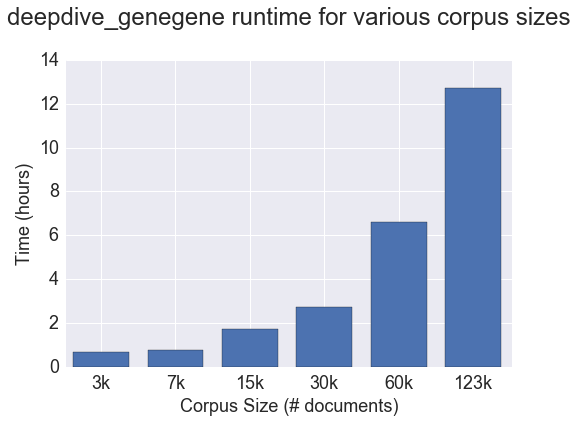

In [7]:
corpus_sizes_int = (3, 7, 15, 30, 60, 123)
corpus_sizes_str = [str(size)+'k' for size in corpus_sizes_int]
corpus_run_times_min = (40,
                        47,
                        60+44,
                        2*60+44,
                        6*60+36,
                        12*60+44
                        )

corpus_run_times_hr = np.array(corpus_run_times_min)/60

x_positions = np.arange(len(corpus_sizes_int))+0.1
width = 0.75

plt.bar(x_positions, corpus_run_times_hr, width, tick_label=corpus_sizes_str)
plt.xticks(x_positions+width/2, corpus_sizes_str)
plt.tick_params(axis='both', labelsize=18)
plt.title('deepdive_genegene runtime for various corpus sizes', fontsize=24, y=1.1)
plt.xlabel('Corpus Size (# documents)', fontsize=18)
plt.ylabel('Time (hours)', fontsize=18)
plt.show()

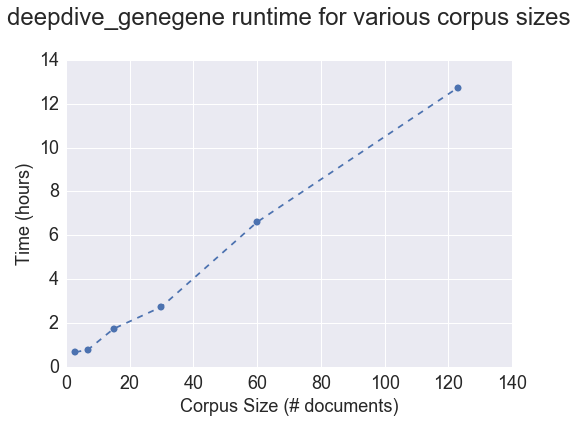

In [8]:
plt.plot(corpus_sizes_int, corpus_run_times_hr, marker='o', linestyle='--')
plt.tick_params(axis='both', labelsize=18)
plt.title('deepdive_genegene runtime for various corpus sizes', fontsize=24, y=1.1)
plt.xlabel('Corpus Size (# documents)', fontsize=18)
plt.ylabel('Time (hours)', fontsize=18)
plt.show()

---
## RAM usage

In [9]:
from collections import OrderedDict

def get_mem_used_free(filename, corpus_name=None):
    
    ''' given an input mem test file, output a tuple of pandas series
        (mem_used, mem_free)
        
        if corpus_name, truncate using global truncation dictionary...
    '''

    with open(filename) as f:
        mem_lines = [line.rstrip('\n') for line in f.readlines() if line.startswith('Mem:')]

    mem_used = OrderedDict()
    mem_free = OrderedDict()

    for line_num, line in enumerate(mem_lines):
        mem_used_val, mem_free_val = [int(x) for x in line.split()[2:4]]
        mem_used[line_num] = mem_used_val
        mem_free[line_num] = mem_free_val

    if corpus_name:
        # truncate each pandas series
        return pd.Series(mem_used)[:corpus_data_endpoints[corpus_name]], pd.Series(mem_free)[:corpus_data_endpoints[corpus_name]]
    else:
        return pd.Series(mem_used), pd.Series(mem_free)

In [10]:
corpus_ram_data = {}

for corpus_size in corpus_data_dict:
    corpus_ram_data[corpus_size] = get_mem_used_free(corpus_data_dict[corpus_size]['ram'], corpus_name=corpus_size)
    
corpus_ram_data.keys()

dict_keys(['3k', '15k', '123k', '30k', '60k', '7k'])

## RAM used for deepdive_genegene runs with corpus sizes of 3k – 123k documents

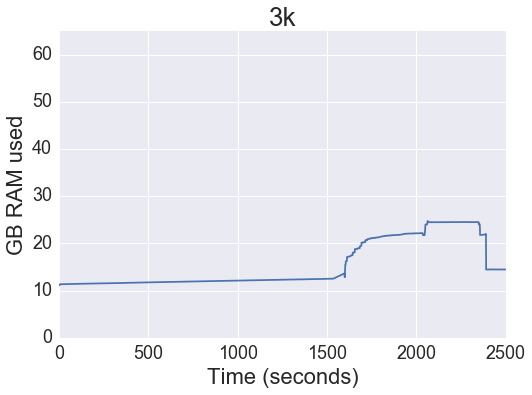

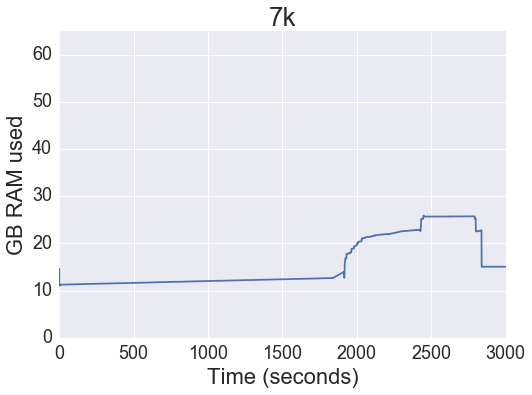

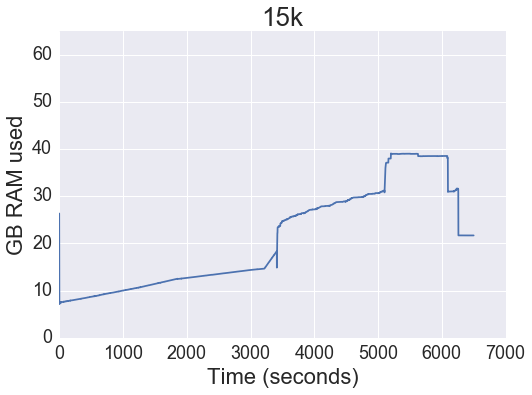

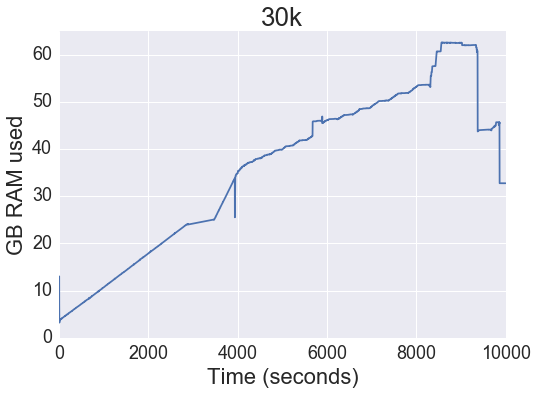

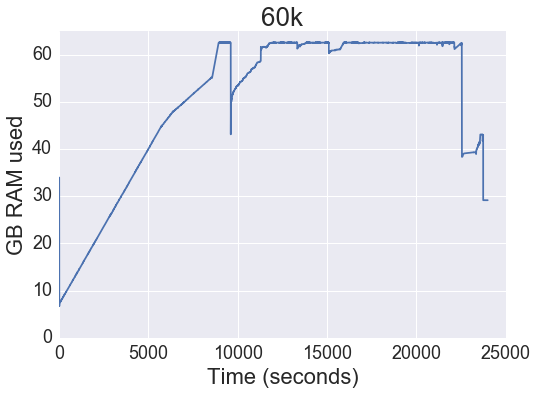

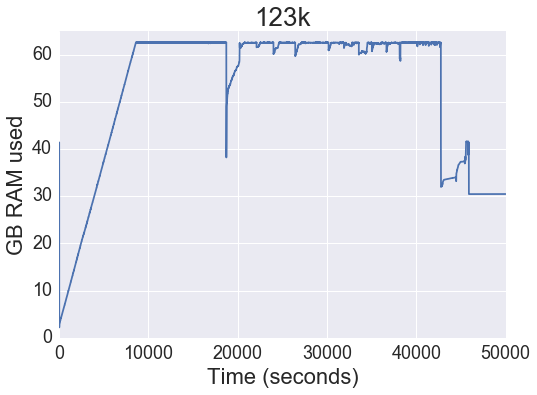

In [11]:
for corpus_size in sorted(corpus_ram_data, key=lambda x: int(x.rstrip('k'))):
    mem_used = corpus_ram_data[corpus_size][0]/1024/1024 # get mem_used from each tuple and convert to GB
    plt.plot(mem_used)
    plt.title(corpus_size, fontsize=26)
    plt.xlabel('Time (seconds)', fontsize=22)
    plt.ylabel('GB RAM used', fontsize=22)
    plt.ylim((0, 65))
    plt.tick_params(labelsize=18, length=0)
    plt.show()

### max RAM usage by corpus size

In [12]:
corpus_max_mem = {corpus_size:corpus_ram_data[corpus_size][0].max() for corpus_size in corpus_ram_data}
corpus_max_mem

{'123k': 65589808,
 '15k': 40963504,
 '30k': 65573064,
 '3k': 25961196,
 '60k': 65573956,
 '7k': 27156416}

In [13]:
max_mem_keys = sorted(corpus_max_mem, key=lambda x: int(x.strip('k')))
max_mem_values = np.array([corpus_max_mem[key] for key in max_mem_keys])/1024/1024
max_mem_keys, max_mem_values

(['3k', '7k', '15k', '30k', '60k', '123k'],
 array([ 24.75852585,  25.89837646,  39.06584167,  62.53534698,
         62.53619766,  62.55131531]))

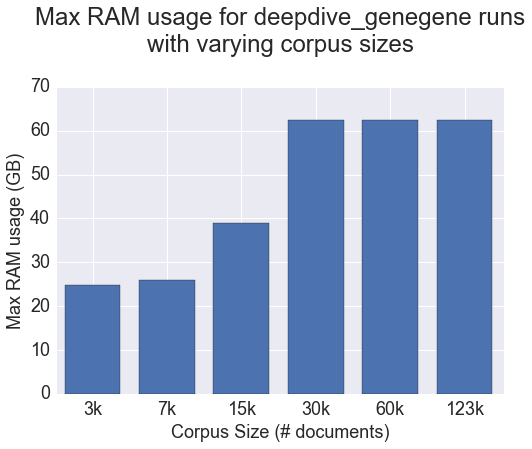

In [14]:
x_positions = np.arange(len(max_mem_keys))+0.1
width = 0.75

plt.bar(x_positions, max_mem_values, width, tick_label=corpus_sizes_str)
plt.xticks(x_positions+width/2, corpus_sizes_str)
plt.tick_params(axis='both', labelsize=18)
plt.title('Max RAM usage for deepdive_genegene runs\nwith varying corpus sizes', fontsize=24, y=1.1)
plt.xlabel('Corpus Size (# documents)', fontsize=18)
plt.ylabel('Max RAM usage (GB)', fontsize=18)
plt.show()

---

## CPU usage

In [15]:
import re

def parse_cpu_data(cpu_data_file, corpus_name=None):
    
    ''' parse CPU data and return a pandas DataFrame where 
        columns are 'Cpu0', 'Cpu1', ...
        
        rows are data points for CPU core usage ('us %')
        
        if corpus_name, truncate after corpus_data_endpoints[corpus_name]
    '''

    cpu_status = defaultdict(OrderedDict)
    # cpu_status will be a dictionary where each key is an OrderedDict
    # (each key in each OrderedDict will be a timepoint)
    # 
    # {'cpu0': OrderedDict([(0, 5.0), (1, 3.0), ...],
    #  'cpu1': OrderedDict([(0, 92.0), (1, 93.0), ...])}

    regex = re.compile(r"^%(Cpu[0-9]+)\s+:\s*(\d+.\d)\sus")

    time_id = -1
    with open(cpu_data_file) as f:
        for line in f:
            if line.startswith('Tasks:'):
                time_id += 1
            matched = regex.match(line)
            if matched:
                cpu_id, val = matched.groups()
                cpu_status[cpu_id][time_id] = float(val)

    len(cpu_status)

    df = pd.DataFrame()
    for cpu_id in sorted(cpu_status):
        df[cpu_id] = pd.Series(cpu_status[cpu_id])

    if corpus_name:
        df = df.truncate(after=corpus_data_endpoints[corpus_name], copy=False)
    
    return df

In [16]:
corpus_cpu_data = {}

for corpus_size in corpus_data_dict:
    corpus_cpu_data[corpus_size] = parse_cpu_data(corpus_data_dict[corpus_size]['cpu'], corpus_name=corpus_size)
    
corpus_cpu_data.keys()

dict_keys(['3k', '15k', '123k', '30k', '60k', '7k'])

In [17]:
corpus_cpu_data['3k'].head()

,Cpu0,Cpu1,Cpu2,Cpu3
0,10.3,10.3,10.3,10.3
1,0.0,3.0,1.0,0.0
2,2.0,2.0,1.0,0.0
3,4.0,77.2,26.5,13.7
4,34.3,55.0,21.4,15.2


In [18]:
import matplotlib.cm as cm


def plot_cpu(df, xlims=None, cores=None, scatter=False):
    
    ''' plot CPU usage by core with xlims = (xmin, xmax)
    '''
    
    plt.figure()

    if cores:
        cores_to_plot = cores
    else:
        cores_to_plot = list(df)

    if scatter:
        colors = cm.viridis(np.linspace(0, 1, len(cores_to_plot)))
        for cpu_id, color in zip(cores_to_plot, colors):
            plt.scatter(df.index, 
                        cpu_id, 
                        data=df, 
                        label=cpu_id, 
                        marker='o', 
                        s=10, 
                        color=color, 
                        edgecolor='black',
                        linewidth=0.3
                       )
    else:
        for cpu_id in cores_to_plot:
            plt.plot(cpu_id, data=df, label=cpu_id)

    if xlims:
        plt.xlim(xlims)
        plt.title('CPU core usage (user cpu time) during DeepDive run {}'.format(xlims), fontsize=24, y=1.1)
    else:
        plt.title('CPU core usage (user cpu time) during DeepDive run', fontsize=24, y=1.1)
        
    plt.ylim((0, 100))
    plt.xlabel('Time (seconds)', fontsize=18)
    plt.ylabel('% CPU core (Us)', fontsize=18)
    plt.tick_params(labelsize=22, length=0)
    plt.legend(fontsize=14, loc='lower left', frameon=True, framealpha=0.9)

    plt.show()

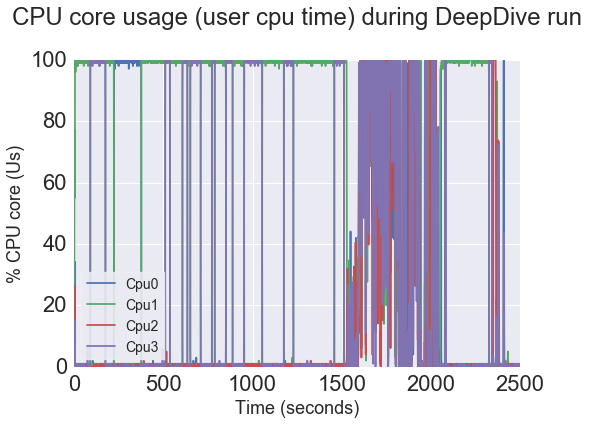

In [19]:
plot_cpu(corpus_cpu_data['3k'])

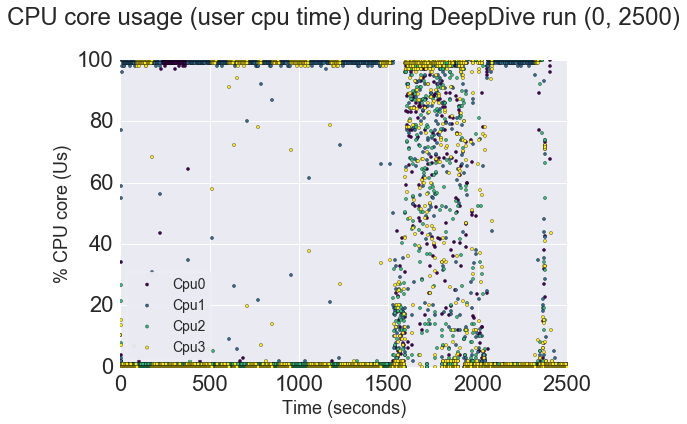

In [20]:
plot_cpu(corpus_cpu_data['3k'], xlims=(0, corpus_cpu_data['3k'].index.max()), scatter=True)

---
## Disk usage

In [21]:
!head {corpus_data_dict['3k']['disk']}

Filesystem     1K-blocks      Used Available Use% Mounted on
/dev/sda1      213030160 135768760  66416984  68% /
none                   4         0         4   0% /sys/fs/cgroup
udev            32950632         8  32950624   1% /dev
tmpfs            6592284      1416   6590868   1% /run
none                5120         0      5120   0% /run/lock
none            32961412       148  32961264   1% /run/shm
none              102400        36    102364   1% /run/user
/dev/sdb1      961303552 302450568 609998476  34% /disk



In [22]:
disk_lines = !grep '^/dev/sdb1' {corpus_data_dict['3k']['disk']}
disk_lines[:5]

['/dev/sdb1      961303552 302450568 609998476  34% /disk',
 '/dev/sdb1      961303552 302450580 609998464  34% /disk',
 '/dev/sdb1      961303552 302450688 609998356  34% /disk',
 '/dev/sdb1      961303552 302452068 609996976  34% /disk',
 '/dev/sdb1      961303552 302452736 609996308  34% /disk']

In [23]:
disk_data_file = corpus_data_dict['123k']['disk']

def parse_disk_data(disk_data_file, corpus_name=None):

    disk_regex = re.compile(r"^/dev/sdb1\s+([0-9]+)\s+([0-9]+)\s+([0-9]+)\s+([0-9]+\%)")
    used_space_data = OrderedDict()
    
    timepoint = -1
    with open(disk_data_file) as f:
        for line in f:
            if line.startswith('Filesystem'):
                timepoint += 1
            match = re.match(disk_regex, line)
            if match:
                _, used_space, *_ = match.groups()
                used_space_data[timepoint] = int(used_space)
                
    if corpus_name:
        return pd.Series(used_space_data)[:corpus_data_endpoints[corpus_name]]/1024/1024
    else:
        return pd.Series(used_space_data)/1024/1024

## disk usage over time

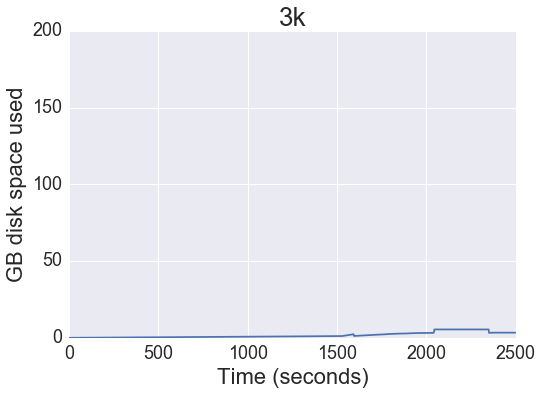

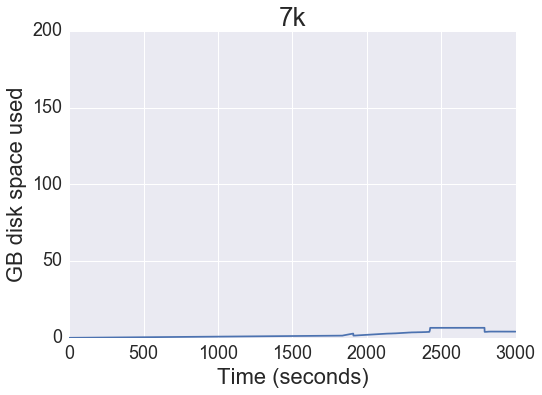

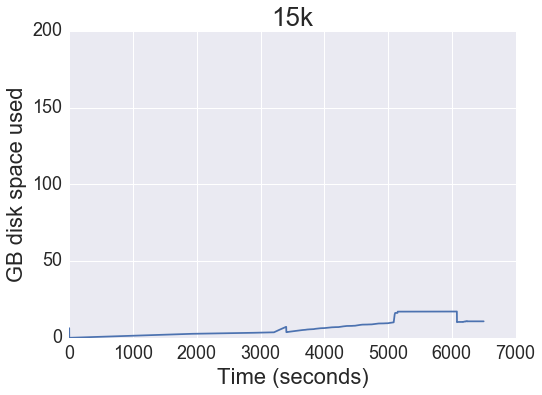

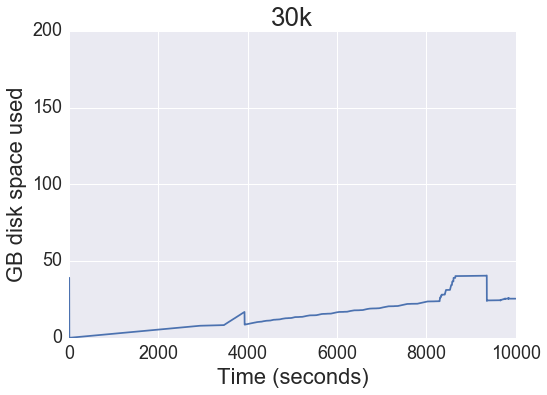

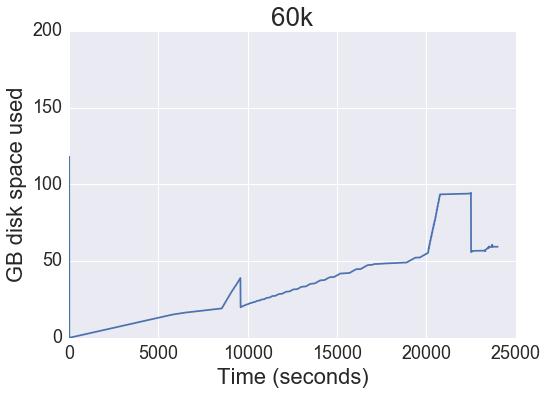

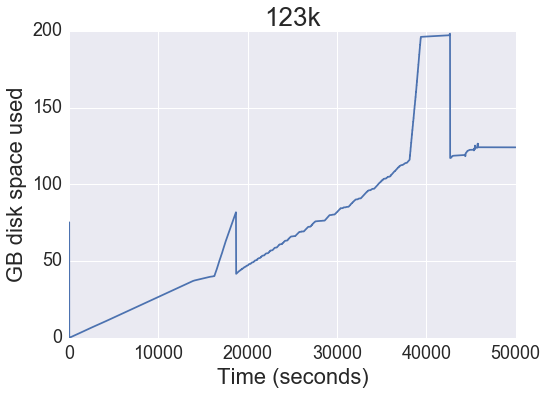

In [24]:
for corpus_size in sorted(corpus_data_dict, key=lambda x: int(x.strip('k'))):
    parsed_data = parse_disk_data(corpus_data_dict[corpus_size]['disk'], corpus_name=corpus_size)
    parsed_data = parsed_data - parsed_data.min()
    plt.plot(parsed_data)
    plt.title(corpus_size, fontsize=26)
    plt.xlabel('Time (seconds)', fontsize=22)
    plt.ylabel('GB disk space used', fontsize=22)
    plt.ylim((0, 200))
    plt.tick_params(labelsize=18, length=0)
    plt.show()

## max disk usage by corpus size

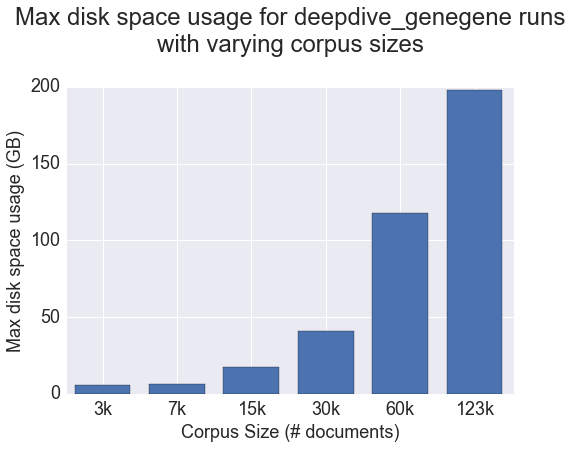

In [25]:
corpus_sizes = []
max_disk_usage = []

for corpus_size in sorted(corpus_data_dict, key=lambda x: int(x.strip('k'))):
    parsed_data = parse_disk_data(corpus_data_dict[corpus_size]['disk'], corpus_name=corpus_size)
    parsed_data = parsed_data - parsed_data.min()
    corpus_sizes.append(corpus_size)
    max_disk_usage.append(parsed_data.max())

plt.bar(x_positions, max_disk_usage, width, tick_label=corpus_sizes)
plt.xticks(x_positions+width/2, corpus_sizes)
plt.tick_params(axis='both', labelsize=18)
plt.title('Max disk space usage for deepdive_genegene runs\nwith varying corpus sizes', fontsize=24, y=1.1)
plt.xlabel('Corpus Size (# documents)', fontsize=18)
plt.ylabel('Max disk space usage (GB)', fontsize=18)
plt.show()